Use a Mini Resnet to classify CIFAR10 
www.bigrabbitdata.com

In [1]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

import PIL.ImageOps
import requests
from PIL import Image

## Data Augmentation for Training data

In [2]:
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.247, 0.243, 0.261])

transform  = transforms.Compose([transforms.Resize((32,32)),
                                 transforms.ToTensor(),
                                 normalize
                                ])
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      normalize
                               ])

training_dataset = datasets.CIFAR10(root='./cifar10', train=True, 
                                  download=True, transform= transform_train)
validation_dataset = datasets.CIFAR10(root='./cifar10', train=False, 
                                  download=True, transform= transform) 

Files already downloaded and verified
Files already downloaded and verified


## Adjust model architecture

In [3]:
# A fixed 3x3 kernel_size conv filter
# Bias term is omited , as the author said it is in the batch_norm layer
# https://github.com/KaimingHe/deep-residual-networks/issues/10#issuecomment-194037195
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    '''
        Conv--> Batchnorm-->ReLu-->Conv-->Batchnorm--> 
        Only downsample if needed
    '''
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        # Only downsample when stride is not 2 
        # or when input channel doesn't match output channel
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(conv3x3(self.in_channels, out_channels, stride=stride),
                                       nn.BatchNorm2d(out_channels))
        layers = []
        # append the first residual block for each layer 
        # downsample the image if needed
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        # append the suceeding residual block in each layer
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

In [5]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda')

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, 
                                              batch_size=100,
                                              shuffle=True)
   
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                              batch_size=100,
                                              shuffle=True)

# Cross Entropy Loss with Adam Optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Set up learning rate scheduler, decay lr by 0.5 every 15 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

train_corrects_history = []
val_corrects_history = []

epochs = 30
for e in range(epochs):

    train_corrects = 0.0 
    train_batch_loss = 0.0
    train_epoch_loss = 0.0
    val_corrects = 0.0
    val_epoch_loss = 0.0
    
    # loop through 60000 samples 100 at a time
    for batch_idx, data in enumerate(training_loader, start=1):
        inputs = data[0].to(device)
        labels = data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Return the index of the highest possibility
        # which are the predicted labels
        _, preds = torch.max(outputs, 1)
        train_batch_loss += loss.item()

        # sum up all the correct prediction
        # since (preds==labels).sum() is a tensor
        # we use item() to extract the number
        train_corrects += (preds == labels).sum().item()

        # print training loss every 100 mini-batch
        # train_batch_loss is the average loss for 100 mini-batch
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                   e + 1 , 
                   batch_idx * len(data[0]), 
                   len(training_loader.dataset),
                   100.* batch_idx * len(data[0]) / len(training_loader.dataset), 
                   train_batch_loss / 100 ))
            # accumulate loss for the epoch
            train_epoch_loss += train_batch_loss
            # reset the loss for every mini-batch
            train_batch_loss = 0.0
    else:
        # torch.no_grad deactivate the auograd engine, 
        # reduce memory usage and speed up computations
        with torch.no_grad():
            for val_data in validation_loader:
                val_inputs = val_data[0].to(device)
                val_labels = val_data[1].to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_epoch_loss += val_loss.item()
                val_corrects += (val_preds == val_labels).sum().item()


        # print result for every epoch 
        train_accuracy = 100. * train_corrects / len(training_loader.dataset)
        train_corrects_history.append(train_accuracy)
        # here batch_idx is the total number of mini-batch = 600
        train_epoch_loss /= batch_idx

        print('epoch :', (e+1))
        print('Train set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                train_corrects, len(training_loader.dataset),
                train_accuracy, train_epoch_loss))


        
        val_accuracy = 100. * val_corrects / len(validation_loader.dataset)
        val_corrects_history.append(val_accuracy)
        val_epoch_loss /= batch_idx

        print('Validation set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                val_corrects, len(validation_loader.dataset),
                val_accuracy, val_epoch_loss))
    
    scheduler.step()

Train Epoch: 1 [10000/50000 (20%)] Loss: 1.797894
Train Epoch: 1 [20000/50000 (40%)] Loss: 1.542277
Train Epoch: 1 [30000/50000 (60%)] Loss: 1.429435
Train Epoch: 1 [40000/50000 (80%)] Loss: 1.320243
Train Epoch: 1 [50000/50000 (100%)] Loss: 1.249881
epoch : 1
Train set: Accuracy: 23043.0/50000 (46%), Average Loss: 1.467946
Validation set: Accuracy: 5873.0/10000 (59%), Average Loss: 0.228339
Train Epoch: 2 [10000/50000 (20%)] Loss: 1.157408
Train Epoch: 2 [20000/50000 (40%)] Loss: 1.129108
Train Epoch: 2 [30000/50000 (60%)] Loss: 1.123871
Train Epoch: 2 [40000/50000 (80%)] Loss: 1.078017
Train Epoch: 2 [50000/50000 (100%)] Loss: 1.032543
epoch : 2
Train set: Accuracy: 30310.0/50000 (61%), Average Loss: 1.104190
Validation set: Accuracy: 6550.0/10000 (66%), Average Loss: 0.194203
Train Epoch: 3 [10000/50000 (20%)] Loss: 1.019314
Train Epoch: 3 [20000/50000 (40%)] Loss: 0.966754
Train Epoch: 3 [30000/50000 (60%)] Loss: 0.980783
Train Epoch: 3 [40000/50000 (80%)] Loss: 0.951569
Train Epoc

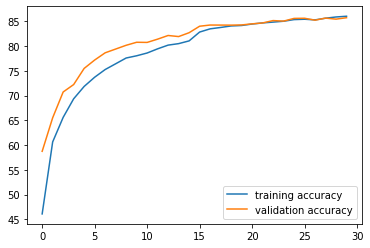

In [6]:
plt.plot(train_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()